In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
import theano
from theano import tensor
import pymc3 as pm

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# generate data set
### - simulate 2D laser mode profiles -

In [3]:
def laserMode(n,m,x,y,w):
    # Hermite–Gaussian Modes
    return abs(( Hmn(np.sqrt(2.)*x/w,m) * np.exp(-x*x/(w*w)) ) * ( Hmn(np.sqrt(2.)*y/w,n) * np.exp(-y*y/(w*w)) ))

def Hmn(x,n):
    if n==0:
        return 1
    elif n==1:
        return 2*x
    else:
        return 2*x*Hmn(x,n-1)-2*(n-1)*Hmn(x,n-2)
    
data = []
targets = []
nb_classes = 3


# create 1000 samples
for sample in range(1000):
    
    # Hermite numbers
    m = 0
    n = np.random.randint(nb_classes)
    
    # mode width
    w = 2
    
    # data storage
    profile = np.zeros((20,20),dtype=float)
    labels = np.zeros((nb_classes),dtype=float)
    labels.put(n,1.)
    
    # generate the 2d data for a random n-Hermite number and add some noise
    for iy,y in enumerate(np.linspace(-5,5,20)):
        for ix,x in enumerate(np.linspace(-5,5,20)):
            profile[iy,ix] = laserMode(m,n,x,y,w) +(n+m+1.)*0.2*np.random.rand()
    data.append(profile)
    targets.append(labels)
    
data = np.array(data)
targets = np.array(targets)

mode_data = {'images':data,'targets':targets}

### show the first 16 mode profiles

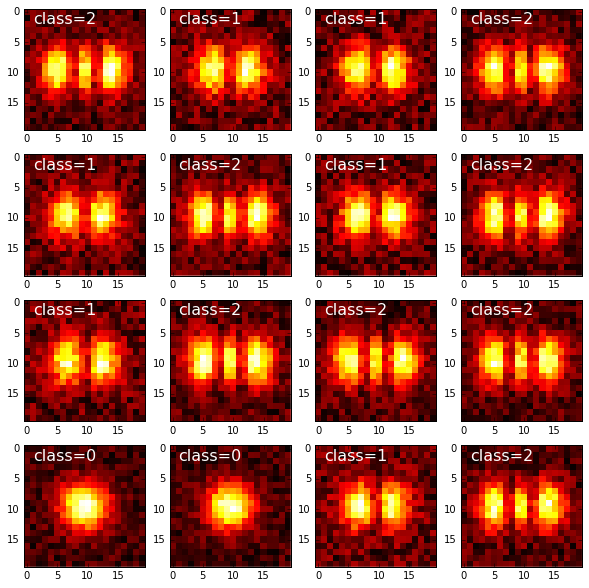

In [4]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(mode_data["images"][i], interpolation = "none", cmap = "hot")
    plt.annotate('class=' + str((mode_data["targets"][i]).argmax()), xy = (1,2),color='w',fontsize=16)

### prepare data for supervised learning

In [5]:
input_train, input_test, output_train, output_test = train_test_split(mode_data['images'], mode_data['targets'],test_size = 0.3)
input_train = input_train.reshape(input_train.shape[0], 20*20)

## set up the bayesian neural network 
#### similar to PyMC3 tutorial http://pymc-devs.github.io/pymc3/notebooks/bayesian_neural_network_advi.html

In [6]:
neural_network_input = theano.shared(input_train)
neural_network_output = theano.shared(output_train)

nb_neurons = 3

# random weights for initialization
init_1 = np.random.randn(input_train.shape[1], nb_neurons)
init_2 = np.random.randn(nb_neurons, nb_neurons)
init_out = np.random.randn(nb_neurons,output_train.shape[1])
    
# build bayesian neural network with normal distributed weights and targets
with pm.Model() as neural_network:
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                             shape=(input_train.shape[1], nb_neurons), 
                             testval=init_1)
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                            shape=(nb_neurons, nb_neurons), 
                            testval=init_2)
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                              shape=(nb_neurons,output_train.shape[1]), 
                              testval=init_out)
    
    activation_1 = tensor.tanh(tensor.dot(neural_network_input, weights_in_1))
    activation_2 = tensor.tanh(tensor.dot(activation_1, weights_1_2))
    activation_out = tensor.nnet.softmax(tensor.dot(activation_2, weights_2_out))
    
    # model target distribution with Normal distribution
    out = pm.Normal('out', activation_out, sd=0.5, observed=neural_network_output)
    

In [7]:
%%time
# do variational inference with ADVI (Automatic Differentation Variational Inference)
with neural_network:
    v_params = pm.variational.advi(n=50000)
    
# sample from fitted distribution
with neural_network:
    trace = pm.variational.sample_vp(v_params, draws=5000)

Iteration 0 [0%]: ELBO = -2414.49
Iteration 5000 [10%]: Average ELBO = -2145.89
Iteration 10000 [20%]: Average ELBO = -1771.04
Iteration 15000 [30%]: Average ELBO = -1471.72
Iteration 20000 [40%]: Average ELBO = -1260.35
Iteration 25000 [50%]: Average ELBO = -1089.75
Iteration 30000 [60%]: Average ELBO = -910.07
Iteration 35000 [70%]: Average ELBO = -808.56
Iteration 40000 [80%]: Average ELBO = -764.39
Iteration 45000 [90%]: Average ELBO = -754.04
Finished [100%]: Average ELBO = -747.68
CPU times: user 1min 28s, sys: 87.3 ms, total: 1min 28s
Wall time: 1min 28s


### change to test set and sample posterior distribution

In [8]:
# change to test set
neural_network_input.set_value(input_test.reshape(input_test.shape[0],20*20))
neural_network_output.set_value(output_test)

# posterior predictive distribution
ppd = pm.sample_ppc(trace, model=neural_network, samples=1000)

### check accuracy of predictions

In [9]:
# use the maximum value of all class means as predictor
check_predictions = [output_test[i,:].argmax()==(ppd['out'].mean(axis=0)[i,:]).argmax() for i in range(output_test.shape[0])]
score = np.array(check_predictions,dtype=float)
print("accuracy = " + str(score.mean()*100) + " %" )

accuracy = 100.0 %


## visualize predictions

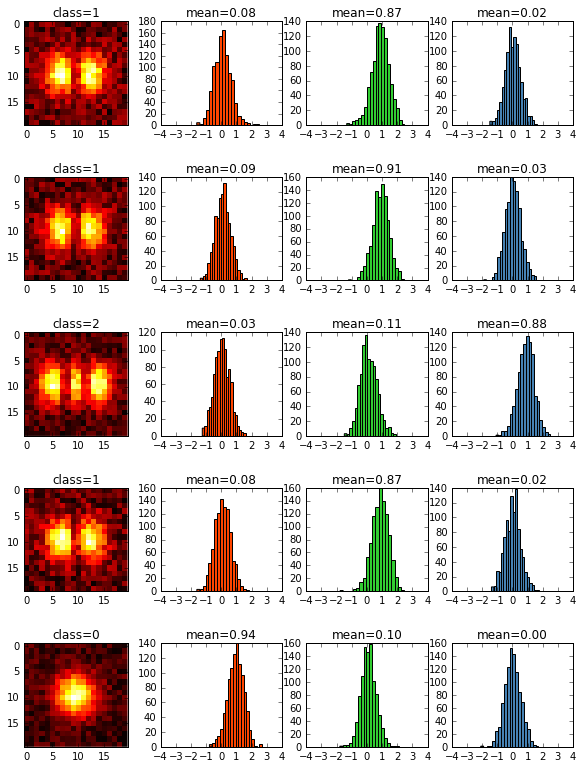

In [10]:
rows = 5
plt.figure(figsize=(10,rows*2.6))
plt.subplots_adjust(hspace=0.5)
ind = 1

# run thru first 'rows' number of samples
# the maximum mean predicts the class label
for i in range(rows):
    plt.subplot(rows,4,ind)
    plt.imshow(input_test[i,:], interpolation = "none", cmap = "hot")
    plt.title('class=' + str((output_test[i,:]).argmax()),color='k')
    for j,c in enumerate(['orangered','limegreen','steelblue']):
        plt.subplot(rows,4,ind+ 1 + j)
        plt.hist(ppd['out'][:,i,j],bins=20,color=c);
        plt.title("{}={:.2f}".format("mean",(ppd['out'][:,i,j]).mean()))
        plt.xlim(-4,4)
    ind += 4